In [ ]:
# video link: https://www.youtube.com/watch?v=8T2emza6g80


In [1]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
from Bio import SeqIO
import os
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

2022-03-25 18:34:56.692027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-25 18:34:56.692048: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig(filename)
    plt.show()

In [31]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [3]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

In [4]:
def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(16)(M1_input)
    M1_dense_2 = Dense(32, activation='relu')(M1_dense_1)
    leaky_relu = LeakyReLU(alpha=0.3)(M1_dense_2)
    drop_out = Dropout(0.5)(leaky_relu)
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model


In [13]:
def embedding_model():
    model = Sequential()
    model.add(Embedding(256, 33, input_length=33))
    model.add(Lambda(lambda x: K.expand_dims(x, 3)))
    model.add(Conv2D(64, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.6))
    model.add(Conv2D(128, (3, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'SAME'))
    model.add(Dropout(0.6))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(768, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [20]:
train_positive_pt5 = pd.read_csv("features/full/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("features/full/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("features/full/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("features/full/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]

# convert sequences to integer encoding, for embedding
test_positive_embedding = get_input_for_embedding('data/test_positive_sites.fasta')
test_negative_embedding = get_input_for_embedding('data/test_negative_sites.fasta')
train_positive_embedding = get_input_for_embedding('data/positive_sites.fasta')
train_negative_embedding = get_input_for_embedding('data/negative_sites.fasta')

# create labels
train_positive_labels = np.ones(train_positive_pt5.shape[0])
train_negative_labels = np.zeros(train_negative_pt5.shape[0])
test_positive_labels = np.ones(test_positive_pt5.shape[0])
test_negative_labels = np.zeros(test_negative_pt5.shape[0])


In [21]:
# stack positive and negative data together
X_train_pt5 = np.vstack((train_positive_pt5, train_negative_pt5))
X_train_embedding = np.vstack((train_positive_embedding,train_negative_embedding))

X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))
X_test_embedding = np.vstack((test_positive_embedding,test_negative_embedding))

y_train = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

In [22]:
# shuffle X and y together
X_train_pt5_full, X_train_embedding_full, y_train = shuffle(X_train_pt5, X_train_embedding, y_train)
X_test_pt5_full, X_test_embedding_full, y_test = shuffle(X_test_pt5, X_test_embedding, y_test)

In [23]:
# combine X_train_pt5, X_train_embedding
X_train_combined = np.hstack([X_train_pt5_full, X_test_pt5_full])

In [10]:
X_train_combined.shape

(9499, 1057)

(7599, 33)
Epoch 1/30
30/30 [==============================] - 10s 305ms/step - loss: 0.7577 - accuracy: 0.5057 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 9s 291ms/step - loss: 0.6935 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 9s 291ms/step - loss: 0.6934 - accuracy: 0.5026 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 9s 291ms/step - loss: 0.6927 - accuracy: 0.5068 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 9s 291ms/step - loss: 0.6929 - accuracy: 0.5091 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 9s 293ms/step - loss: 0.6927 - accuracy: 0.5072 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 9s 289ms/step - loss: 0.6921 - accuracy: 0.5215 - val_loss: 0.6930 - val_accuracy: 0

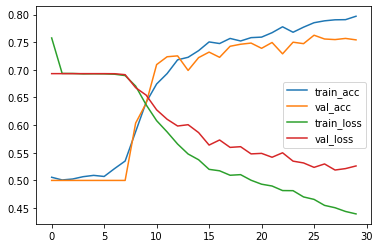

(7599, 33)
Epoch 1/30
30/30 [==============================] - 10s 300ms/step - loss: 0.7939 - accuracy: 0.5032 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 9s 289ms/step - loss: 0.6933 - accuracy: 0.5094 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 9s 289ms/step - loss: 0.6934 - accuracy: 0.5041 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 9s 286ms/step - loss: 0.6935 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 9s 287ms/step - loss: 0.6933 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 9s 285ms/step - loss: 0.6931 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 9s 285ms/step - loss: 0.6928 - accuracy: 0.5211 - val_loss: 0.6931 - val_accuracy: 0

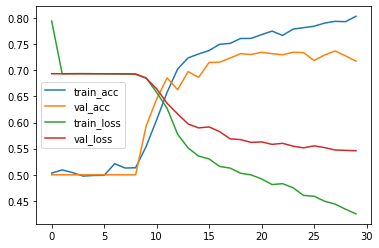

(7599, 33)
Epoch 1/30
30/30 [==============================] - 9s 295ms/step - loss: 0.7967 - accuracy: 0.5036 - val_loss: 0.6931 - val_accuracy: 0.5074
Epoch 2/30
30/30 [==============================] - 9s 284ms/step - loss: 0.6935 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 8s 282ms/step - loss: 0.6930 - accuracy: 0.5034 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 8s 283ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 8s 281ms/step - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 8s 282ms/step - loss: 0.6930 - accuracy: 0.5064 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 9s 285ms/step - loss: 0.6926 - accuracy: 0.5147 - val_loss: 0.6932 - val_accuracy: 0.

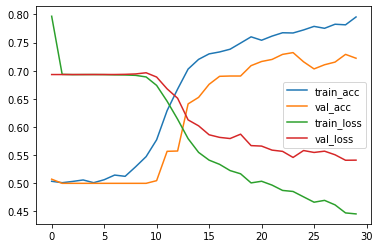

(7599, 33)
Epoch 1/30
30/30 [==============================] - 9s 294ms/step - loss: 0.8455 - accuracy: 0.5044 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 9s 287ms/step - loss: 0.6932 - accuracy: 0.5070 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 9s 291ms/step - loss: 0.6933 - accuracy: 0.4985 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 4/30
30/30 [==============================] - 8s 282ms/step - loss: 0.6936 - accuracy: 0.4989 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 5/30
30/30 [==============================] - 9s 285ms/step - loss: 0.6934 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 8s 282ms/step - loss: 0.6930 - accuracy: 0.5052 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 8s 282ms/step - loss: 0.6928 - accuracy: 0.5093 - val_loss: 0.6931 - val_accuracy: 0.

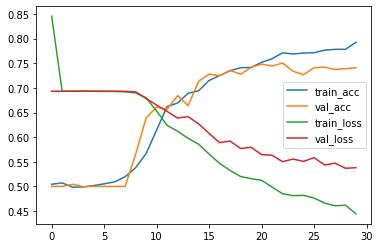

(7600, 33)
Epoch 1/30
30/30 [==============================] - 10s 300ms/step - loss: 0.8791 - accuracy: 0.4912 - val_loss: 0.6931 - val_accuracy: 0.5003
Epoch 2/30
30/30 [==============================] - 9s 288ms/step - loss: 0.6935 - accuracy: 0.5042 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 3/30
30/30 [==============================] - 9s 288ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 4/30
30/30 [==============================] - 9s 290ms/step - loss: 0.6933 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 5/30
30/30 [==============================] - 9s 289ms/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6933 - val_accuracy: 0.4997
Epoch 6/30
30/30 [==============================] - 9s 286ms/step - loss: 0.6929 - accuracy: 0.5046 - val_loss: 0.6933 - val_accuracy: 0.4997
Epoch 7/30
30/30 [==============================] - 9s 287ms/step - loss: 0.6923 - accuracy: 0.5238 - val_loss: 0.6934 - val_accuracy: 0

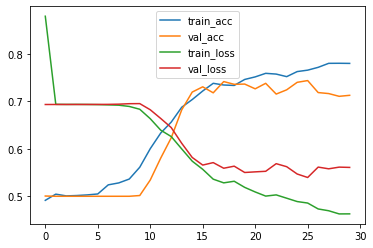

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(5, shuffle=True, random_state=1)

# initialize value of K
iteration = 1
    
for train, val in kfold.split(X_train_combined, y_train):
    train_X, val_X = X_train_combined[train], X_train_combined[val]
    train_y, val_y = y_train[train], y_train[val]

    # Now split data to make it fit in our model
    # X_train_embedding = (n*33), X_train = (n*1024)
    X_train_embedding = train_X[:,1024:]
    X_train_prot_t5 = train_X[:,:1024]
    X_val_embedding = val_X[:,1024:]
    X_val_prot_t5 = val_X[:,:1024]
    
    print(X_train_embedding.shape)
    # Training and Evaluation
    
    
# MODEL A
    model_A = embedding_model()
    model_A.compile(optimizer=Adam(learning_rate=1e-3),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])
    
    checkpointer = ModelCheckpoint(filepath="models/st_model_best.h5",
                                monitor = metric,
                                verbose=0, 
                                save_weights_only=False,
                                save_best_only=True)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')
    
    metric = 'val_accuracy'
    
    history_A = model_A.fit(X_train_embedding, train_y, batch_size=256,epochs=30,verbose=1,callbacks=[checkpointer],
        validation_data=(X_val_embedding, val_y))
    
    # Save model
    model_A.save('models/cv_new/model_A_'+str(iteration)+'.h5')
    
    #save plot
    plot_save(history_A, 'models/cv_new/curves/model_A_'+str(iteration)+'.png')

    
# MODEL B
    model_B = prot_t5_model()
    model_B.compile(optimizer=Adam(learning_rate=1e-3),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,mode='auto')
    
    metric = 'val_accuracy'
    
    history_B = model_B.fit(X_train_prot_t5, train_y, batch_size=256,epochs=30,verbose=1,callbacks=[early_stopping],
        validation_data=(X_val_prot_t5, val_y))
    
    # Save model
    model_B.save('models/cv_new/model_B_'+str(iteration)+'.h5')
    
    #save plot
    plot_save(history_B, 'models/cv_new/curves/model_B_'+str(iteration)+'.png')
    
    # increase iteration
    iteration += 1


## After training models

In [ ]:
# save models
# model_1.save('models/model_1.h5')
# model_2.save('models/model_2.h5')
# model_3.save('models/model_3.h5')

In [ ]:
# open saved models
model_1 = load_model('models/model_1.h5')
model_2 = load_model('models/model_2.h5')
model_3 = load_model('models/model_3.h5')

In [29]:
# load models from file
def load_all_models(model_names):
    all_models = list()
    for model in model_names:
        filename = 'models/cv_new/'+ model + '.h5'
        model = load_model(filename)
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
#             layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
    ensemble_visible = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(4, activation='relu', name = 'ds_1')(merge)
#     hidden = Dropout(0.4, name = 'dp_1')(hidden)
#     hidden = Dense(4, activation='relu', name = 'ds_2')(hidden)

#     hidden = Dense(4, activation='relu', name = 'ds_3')(hidden)
#     hidden = Reshape((1,4))(hidden)
#     hidden = Bidirectional(LSTM(32))(hidden)
#     hidden = Dropout(0.4, name = 'dp_2')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    plot_model(model, show_shapes=True, to_file='ensemble_graph.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# fit a model
def fit_stacked_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))]
    inputy_enc = to_categorical(inputy)
    model.fit(X, inputy_enc, epochs=10, verbose=1)   


# prediction
def predict_stacked_model(model, inputX):
    X = [inputX for _ in range(len(model.input))]
    return model.predict(X, verbose=0)


# load all models
members = load_all_models(['model_A_1', 'model_A_2', 'model_A_3', 'model_A_4', 'model_A_5', 'model_B_1', 'model_B_2', 'model_B_3', 'model_B_4', 'model_B_5'])
print('Loaded %d models' % len(members))
stacked_model = define_stacked_model(members)
# fit_stacked_model(stacked_model, x_test, y_test)
st_history = stacked_model.fit([X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_embedding_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full, X_train_pt5_full],y_train, epochs=10, verbose=1)

>loaded models/cv_new/model_A_1.h5
>loaded models/cv_new/model_A_2.h5
>loaded models/cv_new/model_A_3.h5
>loaded models/cv_new/model_A_4.h5
>loaded models/cv_new/model_A_5.h5
>loaded models/cv_new/model_B_1.h5
>loaded models/cv_new/model_B_2.h5
>loaded models/cv_new/model_B_3.h5
>loaded models/cv_new/model_B_4.h5
>loaded models/cv_new/model_B_5.h5
Loaded 10 models
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/10
297/297 [==============================] - 16s 47ms/step - loss: 0.6070 - accuracy: 0.6629
Epoch 2/10
297/297 [==============================] - 14s 47ms/step - loss: 0.4552 - accuracy: 0.8276
Epoch 3/10
297/297 [==============================] - 14s 48ms/step - loss: 0.3820 - accuracy: 0.8482
Epoch 4/10
297/297 [==============================] - 14s 48ms/step - loss: 0.3520 - accuracy: 0.8590
Epoch 5/10
297/297 [==============================] - 14s 48ms/

KeyError: 'val_accuracy'

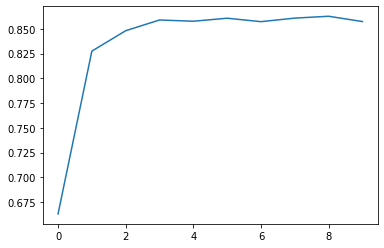

In [32]:
plot(st_history)

In [33]:
y_pred = stacked_model.predict([X_test_embedding, X_test_1, X_test_one_hot]).reshape(y_test.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
y_test = np.array(y_test)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Matthews Correlation : ",matthews_corrcoef(y_test, y_pred))
print("Confusion Matrix :\n",confusion_matrix(y_test, y_pred))
print("Accuracy on test set:   ",accuracy_score(y_test,y_pred))
print("Sensitivity : ",cm[1][1]/(cm[1][1]+cm[1][0]))
print("Specificity: ",cm[0][0]/(cm[0][0]+cm[0][1]))

NameError: name 'stacked_model_1' is not defined

In [26]:
# stacked_model.summary()
plot_model(stacked_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
stacked_model_1.save('models/stacked_model_test_54_5.h5')

In [ ]:
# test saved 